In [1]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr
import seaborn as sns
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [2]:
temp_file='/home/jaya/work/REST3/REST2_REST3/fas_8reps/replica_temp.xvg'

nreps=8

temperature = [ '300','317.89','336.847','356.935','378.22','400.775','424.675','450' ]

In [3]:
# Original Michelle's Code
def calc_round_trip_stack(file, nreps = 20 ):
    """
    xvg = the temp xvg file with the exchanges at every 80ps
    """
    # unpack the xvg file 
    rep_dict = {} # for counting 
    xvg = np.loadtxt(file ,comments=["@", "#"])[:,1:]

    for i in range(nreps): 
        rep = xvg[:,i]
        rep_dict[i] = 0 
        stack = []
        for e in rep:
            # reinstantiate list 
            if len(stack) == nreps: 
                rep_dict[i] += 0.5
                # rep_dict[i]+=1.0
                stack = []
            elif int(e) not in stack: 
                stack.append(int(e))
    
    return rep_dict

# Updated Michelle's Code
def calc_round_trip_stack_(file, nreps = 20 ):
    """
    xvg = the temp xvg file with the exchanges at every 80ps
    """
    # unpack the xvg file 
    rep_dict = {} # for counting 
    xvg = np.loadtxt(file ,comments=["@", "#"])[:,1:]

    for i in range(nreps): 
        rep = xvg[:,i]
        rep_dict[i] = 0 
        stack = []
        for e in rep:
            # reinstantiate list 
            if len(stack) == nreps: 
                # rep_dict[i] += 0.5
                rep_dict[i]+=1.0
                stack = []
            elif int(e) not in stack: 
                stack.append(int(e))
                
            
        if rep_dict[i]%2 : 
#             print (i,rt[i]/2-0.5)
            rep_dict[i]=((rep_dict[i]-1)/2)
        else :
#             print (i,rt[i]/2)
            rep_dict[i]=rep_dict[i]/2
    
    return rep_dict

# Corrected Michelle's Code
def calc_round_trip_stack_1(file, nreps = 20 ):
    """
    xvg = an xvg file with the exchanges at every exchange attempt 80ns
    """
    # unpack the xvg file 
    rep_dict = {} # for counting 
    xvg = np.loadtxt(file ,comments=["@", "#"])[:,1:]

    for i in range(nreps): 
        rep = xvg[:,i]
        rep_dict[i] = 0 
        stack = []
        for e in rep:
            # reinstantiate list 
            if int(e) not in stack: 
                stack.append(int(e))
            if len(stack) == nreps:
                rep_dict[i] += 1
                stack = []
        
        
        if rep_dict[i]%2 : 
#             print (i,rt[i]/2-0.5)
            rep_dict[i]=((rep_dict[i]-1)/2)
        else :
#             print (i,rt[i]/2)
            rep_dict[i]=rep_dict[i]/2

    return rep_dict



In [4]:
rt=calc_round_trip_stack(temp_file, nreps=nreps)
rt_=calc_round_trip_stack_(temp_file, nreps=nreps)
rt_1=calc_round_trip_stack_1(temp_file, nreps=nreps)

In [5]:
print(f"Original : {rt}") 
print()
print(f"Updated : {rt_}")
print()
print(f"Corrected : {rt_1}")

Original : {0: 1222.0, 1: 1255.5, 2: 1255.0, 3: 1187.0, 4: 1294.0, 5: 1226.5, 6: 1218.5, 7: 1224.0}

Updated : {0: 1222.0, 1: 1255.0, 2: 1255.0, 3: 1187.0, 4: 1294.0, 5: 1226.0, 6: 1218.0, 7: 1224.0}

Corrected : {0: 1288.0, 1: 1328.0, 2: 1328.0, 3: 1257.0, 4: 1356.0, 5: 1296.0, 6: 1296.0, 7: 1295.0}


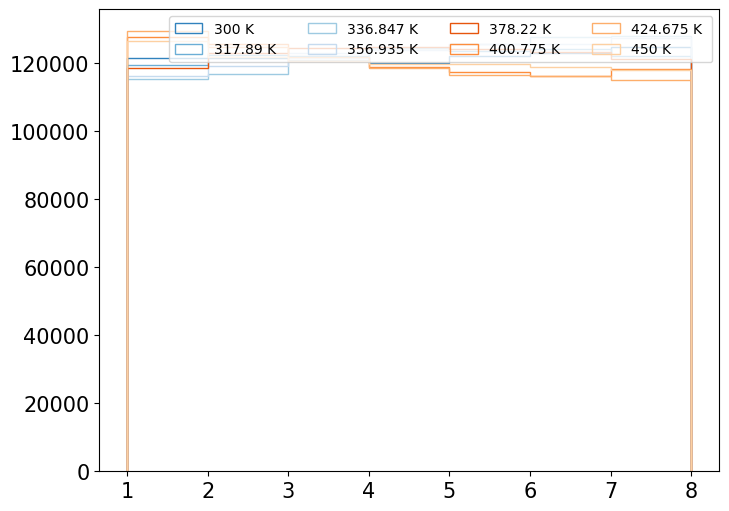

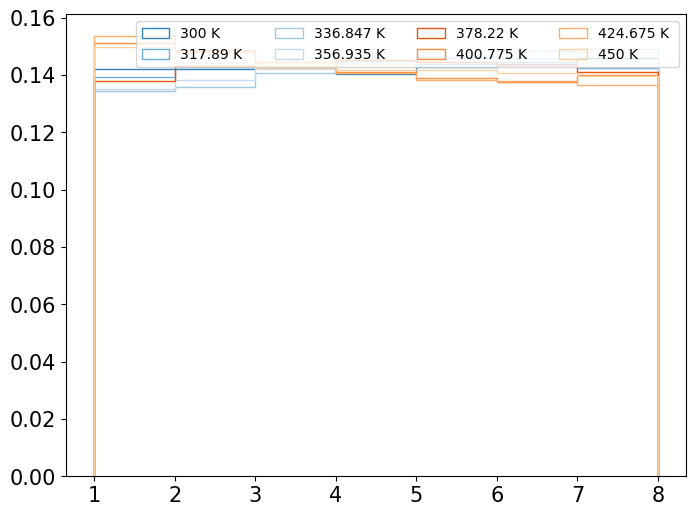

In [6]:
# Michelle's code

temp_xvg = np.loadtxt(temp_file ,comments=["@", "#"])[:,1:]

plt.figure(figsize=(8,6))
plt.tick_params(labelsize=15)

for i in range(nreps): 
        rep = temp_xvg[:,i]
        plt.hist(rep,range= (1,nreps),histtype= "step", label= str(temperature[i]) + " K ",
                color=plt.cm.tab20c(i),bins=nreps-1)

plt.legend(loc = "upper right",ncols=4)

plt.figure(figsize=(8,6))
plt.tick_params(labelsize=15)

for i in range(nreps): 
        rep = temp_xvg[:,i]
        plt.hist(rep,range= (1,nreps),histtype= "step",density='true', label= str(temperature[i]) + " K ",
                color=plt.cm.tab20c(i),bins=nreps-1)

plt.legend(loc = "upper right",ncols=4)


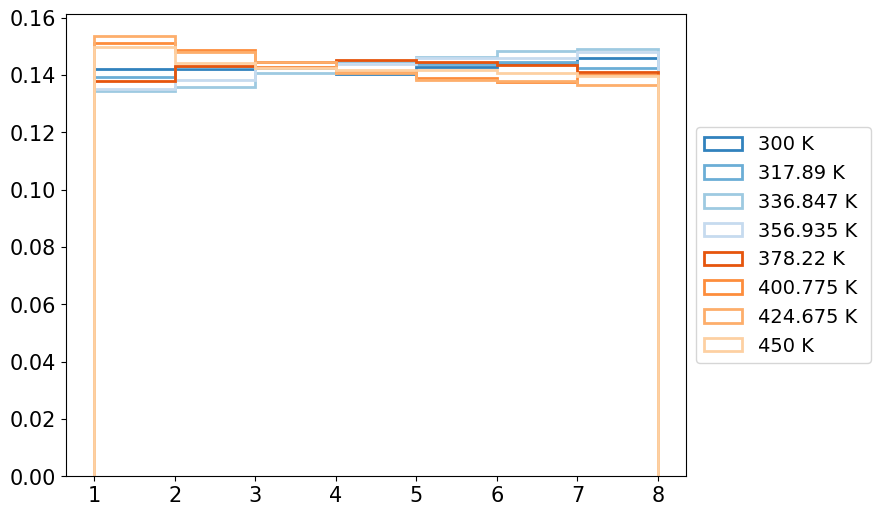

In [7]:
# My code
plt.figure(figsize=(8,6))
for i in range(nreps):
    plt.hist(temp_xvg.T[i],range= (1,nreps),histtype='step',density='true',linewidth=2,
             color=plt.cm.tab20c(i),label=str(temperature[i]) + " K ",bins=nreps-1)
    
plt.tick_params(labelsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

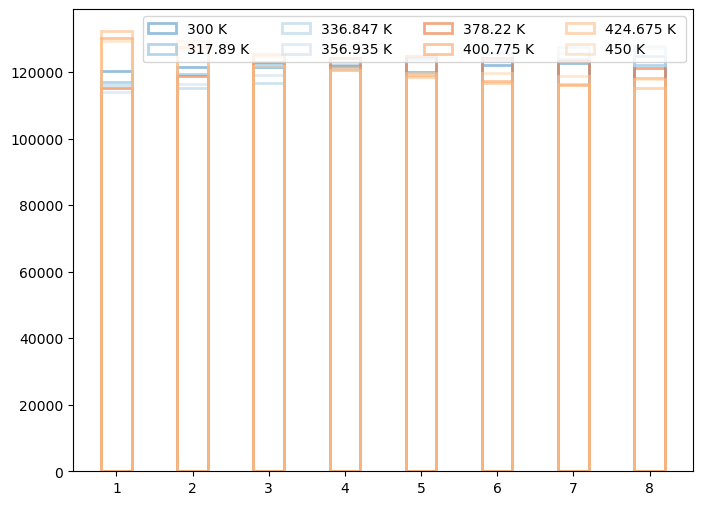

In [8]:
# Michelle's bar plot code
# load in the xvg file and create barplot of the count  
# file = "./replica_temp.xvg"
# temp_xvg = np.loadtxt(file ,comments=["@", "#"])[:,1:]

plt.figure(figsize=(8,6))

for i in range(nreps):
        ls = [] 
        rep = temp_xvg[:,i]
        for j in range(nreps):
                count = np.sum(np.where(rep == j, 1, 0))
                ls.append(count)
        plt.bar(range(1,nreps+1), height = ls, label= str(temperature[i]) + " K ", alpha = 0.5, edgecolor=plt.cm.tab20c(i), color='None', lw=2, width = 0.4)

plt.legend(loc = "upper right",ncols=4)

## Here rt is updated in the next iteration of stack satisfying the condition (all reps are visited)

In [20]:
# Michalle's Code

rep_dict = {} # for counting 
xvg = np.loadtxt(temp_file ,comments=["@", "#"])[:,1:]
n=0
r=[1]

for i in r: 
    rep = xvg[:,i][::2000]
    rep_dict[i] = 0 
    stack = []
    n=0
    for e in rep:
        # reinstantiate list
        n+=1
        if len(stack) == nreps:
            print()
            print("\033[91m"+f"##=>n={n}; e={e}; len_stack={len(stack)}")
            rep_dict[i] += 1.0
            stack = []
            print("\033[91m"+f"##=>rt={rep_dict[i]}\n")
        elif int(e) not in stack: 
            stack.append(int(e))
            print("\033[90m"+f"stack={stack}; n={n}; e={e}")


 

stack=[1]; n=1; e=1.0
stack=[1, 5]; n=2; e=5.0
stack=[1, 5, 2]; n=3; e=2.0
stack=[1, 5, 2, 6]; n=4; e=6.0
stack=[1, 5, 2, 6, 4]; n=5; e=4.0
stack=[1, 5, 2, 6, 4, 7]; n=6; e=7.0
stack=[1, 5, 2, 6, 4, 7, 3]; n=8; e=3.0
stack=[1, 5, 2, 6, 4, 7, 3, 0]; n=19; e=0.0

##=>n=20; e=3.0; len_stack=8
##=>rt=1.0

stack=[0]; n=21; e=0.0
stack=[0, 6]; n=22; e=6.0
stack=[0, 6, 3]; n=24; e=3.0
stack=[0, 6, 3, 7]; n=27; e=7.0
stack=[0, 6, 3, 7, 2]; n=28; e=2.0
stack=[0, 6, 3, 7, 2, 1]; n=32; e=1.0
stack=[0, 6, 3, 7, 2, 1, 5]; n=38; e=5.0
stack=[0, 6, 3, 7, 2, 1, 5, 4]; n=54; e=4.0

##=>n=55; e=2.0; len_stack=8
##=>rt=2.0

stack=[5]; n=56; e=5.0
stack=[5, 4]; n=57; e=4.0
stack=[5, 4, 2]; n=58; e=2.0
stack=[5, 4, 2, 3]; n=59; e=3.0
stack=[5, 4, 2, 3, 6]; n=61; e=6.0
stack=[5, 4, 2, 3, 6, 0]; n=63; e=0.0
stack=[5, 4, 2, 3, 6, 0, 7]; n=67; e=7.0
stack=[5, 4, 2, 3, 6, 0, 7, 1]; n=88; e=1.0

##=>n=89; e=7.0; len_stack=8
##=>rt=3.0

stack=[2]; n=90; e=2.0
stack=[2, 7]; n=91; e=7.0
stack=[2, 7, 3]; n=92; e=3.0

## Here rt is updated in the same iteration of stack satisfying the condition (all reps are visited)

In [21]:
# Edited code

rep_dict = {} # for counting 
xvg = np.loadtxt(temp_file ,comments=["@", "#"])[:,1:]
n=0
r=[1]

for i in r: 
    rep = xvg[:,i][::2000]
    rep_dict[i] = 0 
    stack = []
    n=0
    for e in rep:
        # reinstantiate list
        n+=1
        if int(e) not in stack:
            stack.append(int(e))
            print("\033[90m"+f"stack={stack}; n={n}; e={e}")
        if len(stack) == nreps:
            print()
            print("\033[91m"+f"##=>n={n}; e={e}; len_stack={len(stack)}")
            rep_dict[i] += 1
            stack = []
            print("\033[91m"+f"##=>rt={rep_dict[i]}\n")

            

stack=[1]; n=1; e=1.0
stack=[1, 5]; n=2; e=5.0
stack=[1, 5, 2]; n=3; e=2.0
stack=[1, 5, 2, 6]; n=4; e=6.0
stack=[1, 5, 2, 6, 4]; n=5; e=4.0
stack=[1, 5, 2, 6, 4, 7]; n=6; e=7.0
stack=[1, 5, 2, 6, 4, 7, 3]; n=8; e=3.0
stack=[1, 5, 2, 6, 4, 7, 3, 0]; n=19; e=0.0

##=>n=19; e=0.0; len_stack=8
##=>rt=1

stack=[3]; n=20; e=3.0
stack=[3, 0]; n=21; e=0.0
stack=[3, 0, 6]; n=22; e=6.0
stack=[3, 0, 6, 7]; n=27; e=7.0
stack=[3, 0, 6, 7, 2]; n=28; e=2.0
stack=[3, 0, 6, 7, 2, 1]; n=32; e=1.0
stack=[3, 0, 6, 7, 2, 1, 5]; n=38; e=5.0
stack=[3, 0, 6, 7, 2, 1, 5, 4]; n=54; e=4.0

##=>n=54; e=4.0; len_stack=8
##=>rt=2

stack=[2]; n=55; e=2.0
stack=[2, 5]; n=56; e=5.0
stack=[2, 5, 4]; n=57; e=4.0
stack=[2, 5, 4, 3]; n=59; e=3.0
stack=[2, 5, 4, 3, 6]; n=61; e=6.0
stack=[2, 5, 4, 3, 6, 0]; n=63; e=0.0
stack=[2, 5, 4, 3, 6, 0, 7]; n=67; e=7.0
stack=[2, 5, 4, 3, 6, 0, 7, 1]; n=88; e=1.0

##=>n=88; e=1.0; len_stack=8
##=>rt=3

stack=[7]; n=89; e=7.0
stack=[7, 2]; n=90; e=2.0
stack=[7, 2, 3]; n=92; e=3.0
stack